In [2]:
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np

try:
  import google.colab
  IN_COLAB = True
  drive.mount('/content/drive')
except:
  IN_COLAB = False


In [3]:
if IN_COLAB:
    imdb_path = "/content/drive/MyDrive/Colab Notebooks/dataset/imdb_simple/IMDB Dataset.csv"
else:
    imdb_path = "dataset/IMDB Dataset.csv"

imdb_df = pd.read_csv(imdb_path)
print(len(imdb_df))

imdb_df['sentiment'].value_counts()
imdb_sentiment = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
print(imdb_sentiment.value_counts())

x = imdb_df['review'].to_numpy()
y = imdb_sentiment.to_numpy()
print(len(x), len(y))
print(x.shape, y.shape)
print(x[0])
print(y[0])

50000
sentiment
1    25000
0    25000
Name: count, dtype: int64
50000 50000
(50000,) (50000,)
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agree

In [4]:
# clearning text
import re

def clean_sentences(line):
    
    line=re.sub('<.*?>','',line) # removing html tags
    
    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)
    
    #removing punctuations
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line

x = [clean_sentences(entry) for entry in x]

### word level tokenization 

In [5]:
# data statistics
word_cnt = {}
len_list = []
for entry in x:
    length = 0
    for word in entry.split():
        word = word.lower()
        length += 1
        if word not in word_cnt:
            word_cnt[word] = 0
        word_cnt[word] = word_cnt[word] + 1
    len_list.append(length)

print("max sentence length:", np.max(len_list))
print("mean sentence length:", np.mean(len_list))
print("median sentence length:", np.median(len_list))

print("word max_size:", len(word_cnt))

max sentence length: 2791
mean sentence length: 274.30138
median sentence length: 206.0
word max_size: 104883


In [6]:
# make 10000 vocab

top_10000_word = sorted(word_cnt.items(), key=lambda item: item[1], reverse=True)[:10000]
vocab = {'<PAD>':0, '<UNK>':1}
for item in top_10000_word:
    vocab[item[0]] = len(vocab)

print(vocab)


# make word to integer token and add pad or truncate
max_len = 100
x_word_token = []
len_list = []
for entry in x:
    sentence = []
    for word in entry.split()[:max_len]:
        word = word.lower()
        token = vocab[word] if word in vocab else vocab['<UNK>']
        sentence.append(token)
    pad_size = max_len - len(sentence)
    if pad_size > 0:
        sentence.extend([0]*pad_size)
    x_word_token.append(sentence)

print("vocab size:", len(vocab))

{'<PAD>': 0, '<UNK>': 1, 'the': 2, '.': 3, ',': 4, 'and': 5, 'a': 6, 'of': 7, 'to': 8, 'is': 9, 'it': 10, 'in': 11, "'": 12, 'i': 13, 'this': 14, 'that': 15, '-': 16, '"': 17, 'was': 18, 'not': 19, 'as': 20, 'movie': 21, 'for': 22, 'with': 23, 's': 24, 'but': 25, 'film': 26, ')': 27, '(': 28, 'you': 29, 'on': 30, 'are': 31, 'have': 32, 'he': 33, 'his': 34, 'one': 35, 'be': 36, '!': 37, 'all': 38, 'at': 39, 'they': 40, 'by': 41, 'an': 42, 'who': 43, 'so': 44, 'from': 45, 'like': 46, 'there': 47, 'or': 48, 'just': 49, 'her': 50, 'out': 51, 'about': 52, 'if': 53, 'has': 54, 'do': 55, '?': 56, 'what': 57, 't': 58, 'some': 59, 'good': 60, 'can': 61, 'when': 62, 'more': 63, 'very': 64, 'would': 65, 'she': 66, 'up': 67, 'no': 68, 'time': 69, 'my': 70, 'even': 71, 'which': 72, 'only': 73, 'story': 74, 'really': 75, 'see': 76, 'their': 77, 'were': 78, 'had': 79, 'me': 80, 'well': 81, 'we': 82, 'will': 83, ':': 84, 'than': 85, 'much': 86, 'could': 87, 'bad': 88, 'get': 89, 'been': 90, 'other': 9

In [7]:
for i in range(4):
    print(len(x_word_token[i]))
    print(x_word_token[i])

100
[35, 7, 2, 91, 2076, 54, 1073, 15, 110, 161, 49, 318, 3120, 409, 29, 12, 257, 36, 3228, 3, 40, 31, 217, 4, 20, 14, 9, 630, 57, 606, 23, 80, 3, 2, 99, 160, 15, 3272, 80, 52, 3120, 18, 102, 5425, 5, 1, 148, 7, 577, 4, 72, 280, 11, 217, 45, 2, 664, 153, 3, 1755, 80, 4, 14, 9, 19, 6, 129, 22, 2, 7958, 2350, 48, 1, 3, 14, 129, 2614, 68, 5962, 23, 5573, 8, 1482, 4, 387, 48, 577, 3, 102, 9, 3851, 4, 11, 2, 371, 372, 7, 2, 664, 3]
100
[6, 405, 133, 366, 3, 2, 1390, 2996, 9, 64, 1, 16, 64, 169, 16, 69, 16, 2273, 1594, 5, 425, 6, 1, 4, 5, 543, 1, 4, 296, 7, 1851, 8, 2, 453, 426, 3, 2, 162, 31, 575, 81, 2289, 16, 498, 4199, 19, 73, 17, 54, 204, 38, 2, 1, 17, 25, 33, 54, 38, 2, 2304, 191, 3304, 107, 37, 29, 61, 383, 76, 2, 1, 798, 9759, 41, 2, 1853, 8, 1747, 12, 7375, 6649, 4, 19, 73, 9, 10, 81, 291, 2, 161, 25, 10, 9, 6, 1, 419, 5, 2410, 426, 3, 6]
100
[13, 205, 14, 18, 6, 405, 106, 8, 1163, 69, 30, 6, 107, 875, 1480, 2615, 4, 1249, 11, 2, 904, 1, 776, 5, 161, 6, 650, 16, 2350, 214, 3, 2, 125

In [8]:
x_word_token = np.array(x_word_token)
x_word_token_tensors = torch.tensor(x_word_token, dtype=torch.long)
y_tensors = torch.tensor(y, dtype=torch.long)
print(x_word_token_tensors.shape)
print(y_tensors.shape)

torch.Size([50000, 100])
torch.Size([50000])


In [9]:
config = {
    'batch_size':256,
    'vocab_size':len(vocab),
    'embedding_dim':200,
    'hidden_size':128,
    'num_layers':1,
    'dropout':0,
}

In [10]:
imdb_dataset = TensorDataset(x_word_token_tensors, y_tensors)
train_dataset, val_dataset, test_dataset = random_split(imdb_dataset, [0.7, 0.15, 0.15])
print(f"train dataset:{len(train_dataset)}, val dataset:{len(val_dataset)}, test dataset:{len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)


train dataset:35000, val dataset:7500, test dataset:7500


In [11]:
class SimpleRNN(nn.Module):
    def __init__(self, config, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config['vocab_size'], 
            embedding_dim=config['embedding_dim']
            )
        self.rnn = nn.RNN(
            input_size=config['embedding_dim'], 
            hidden_size=config['hidden_size'], 
            num_layers=config['num_layers'], 
            batch_first=True, 
            dropout=config['dropout']
            )
        self.fnn = nn.Linear(
            in_features=config['hidden_size'], 
            out_features=1
            )
        
    def forward(self, x):
        out = self.embedding(x)
        output, _ = self.rnn(out)
        # output ( batch, seq_len, input_size)
        last_output = output[:, -1, :].squeeze()
        # last_output = (batch, input_size)
        out = self.fnn(last_output)
        return out

model = SimpleRNN(config)
sample_input = train_dataset[:config['batch_size']][0]
print(sample_input.shape)
test = model(sample_input)
print(test.shape)

torch.Size([256, 100])
torch.Size([256, 1])


In [12]:
from tqdm import tqdm
import io

class Trainer():
    def __init__(self, config, model, train_dataloader, val_dataloader) -> None:
        self.config = config
        self.model = model
        self.model_name = model.__class__.__name__
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = config['device'] if 'device' in config else "cpu"
        self.num_of_epoch = config['epoch'] if 'epoch' in config else 10
        self.lr = config['learning_rate'] if 'learning_rate' in config else 1e-2
        self.patience = config['patience'] if 'patience' in config else 5
        self.output_dir = config['output'] if 'output' in config else "output/"
        

    def train(self):
        train_loss_history = []
        train_accuracy_history = []
        val_loss_history = []
        val_accuarcy_history = []

        self.model = self.model.to(self.device)

        best_epoch = 0
        best_loss = np.inf
        epochs_no_improve = 0
        buffer = io.BytesIO()
        
        criterion = nn.BCEWithLogitsLoss()
        print(f"start training : lr={self.lr}")
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        pbar = tqdm(range(self.num_of_epoch))
        for epoch in pbar:
            self.model.train()
            epoch_loss = 0
            total_count = 0
            total_correct = 0
            
            for step, batch in enumerate(self.train_dataloader):
                x = batch[0].to(self.device)
                y = batch[1].to(self.device)

                optimizer.zero_grad()
                
                y_pred = self.model(x)
                y_target = y.unsqueeze(-1).float()

                loss = criterion(y_pred, y_target)
                epoch_loss += loss.item() * y_target.shape[0]
                loss.backward()
                optimizer.step()

                correct, _ = self.calc_accuracy(y_pred, y_target)
                total_correct += correct
                total_count += y_target.shape[0]
            
            epoch_loss_mean = epoch_loss / total_count
            accuracy = total_correct / total_count
            val_loss_mean, val_accuracy = self.validation()
            pbar.set_postfix_str(f"train_loss={epoch_loss_mean:.5f}, val_loss={val_loss_mean:.5f}, train_accu={accuracy:.2f} val_accu={val_accuracy:.2f}")
            
            train_loss_history.append(epoch_loss_mean)
            train_accuracy_history.append(accuracy)
            
            val_loss_history.append(val_loss_mean)
            val_accuarcy_history.append(val_accuracy)

            if val_loss_mean < best_loss:
                best_loss = val_loss_mean
                epochs_no_improve = 0
                best_epoch = epoch
                
                buffer.seek(0)
                buffer.truncate()
                torch.save(model.state_dict(), buffer)
                buffer.seek(0)
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= self.patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        output_path = os.path.join(self.output_dir, f"{self.model_name}_ep_{best_epoch}_loss_{best_loss:.4f}.pt")
        print(output_path)
        with open(output_path, mode='wb') as f:
            f.write(buffer.getbuffer())

        return (train_loss_history, train_accuracy_history, val_loss_history, val_accuarcy_history), output_path
    
    def validation(self):
        return self.test(self.model, self.val_dataloader)

    def test(self, model, dataloader):
        model.eval()
        criterion = nn.BCEWithLogitsLoss()
        epoch_loss = 0
        total_count = 0
        total_correct = 0
        for _, batch in enumerate(dataloader):
            x = batch[0].to(self.device)
            y = batch[1].to(self.device)

            y_pred = self.model(x)
            y_target = y.unsqueeze(-1).float()
            loss = criterion(y_pred, y_target)
            epoch_loss += loss.item() * y_target.shape[0]

            correct, _ = self.calc_accuracy(y_pred, y_target)
            total_correct += correct
            total_count += y_target.shape[0]
        
        epoch_loss_mean = epoch_loss / total_count
        accuracy = total_correct / total_count
        return epoch_loss_mean, accuracy
                        
    def calc_accuracy(self, y_pred, y_target):
        y_pred_np = y_pred.squeeze().detach().cpu().numpy()
        y_target_np = y_target.squeeze().detach().cpu().numpy()
        label_pred_np = (y_pred_np > 0.5).astype(np.int32)
        label_target_np = y_target_np.astype(np.int32)

        correct = np.sum(label_pred_np == label_target_np)
        return correct, correct / len(label_pred_np)
            



In [13]:
config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['epoch'] = 100
config['learning_rate'] = 1e-4
config['embedding_dim'] = 64
config['hidden_size'] = 256
model = SimpleRNN(config)
trainer = Trainer(config, model, train_dataloader, val_dataloader)
history, last_ckpt_path = trainer.train()

start training : lr=0.0001


 58%|█████▊    | 58/100 [00:33<00:24,  1.73it/s, train_loss=0.35871, val_loss=0.50879, train_accu=0.85 val_accu=0.78]

Early stopping at epoch 58
output/SimpleRNN_ep_53_loss_0.4895.pt


In [1]:
import matplotlib.pyplot as plt

def show_history_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

    ax1.plot(history[0], label='train')
    ax1.plot(history[2], label='val')
    ax1.legend()

    ax2.plot(history[1], label='train')
    ax2.plot(history[3], label='val')
    ax2.legend()

    plt.tight_layout()
    plt.show()

show_history_graph(history)

NameError: name 'history' is not defined

In [48]:
print(last_ckpt_path)
model = SimpleRNN(config)
state_dict = torch.load(last_ckpt_path)
model.load_state_dict(state_dict)
model.to(config['device'])

loss, accuracy = trainer.test(model, test_dataloader)
print(f"test loss : {loss:.4f}, accuracy : {accuracy:.2f}")


output/SimpleRNN_ep_56_loss_0.5356.pt
test loss : 0.5447, accuracy : 0.73


# USE LSTM

In [54]:
class TorchLSTM(nn.Module):
    def __init__(self, config, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config['vocab_size'], 
            embedding_dim=config['embedding_dim']
            )
        self.lstm = nn.LSTM(
            input_size=config['embedding_dim'], 
            hidden_size=config['hidden_size'], 
            num_layers=config['num_layers'], 
            bidirectional=True,
            batch_first=True, 
            dropout=config['dropout']
        )
        self.fnn = nn.Linear(
            in_features=config['hidden_size'] * 2, 
            out_features=1
            )
        
    def forward(self, x):
        out = self.embedding(x)
        output, _ = self.lstm(out)
        # output ( batch, seq_len, input_size)
        last_output = output[:, -1, :].squeeze()
        # last_output = (batch, input_size)
        out = self.fnn(last_output)
        return out

model = TorchLSTM(config)
sample_input = train_dataset[:config['batch_size']][0]
print(sample_input.shape)
test = model(sample_input)
print(test.shape)

torch.Size([256, 100])
torch.Size([256, 1])


start training : lr=0.0001


  0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 31/100 [00:46<01:42,  1.49s/it, train_loss=0.31722, val_loss=0.50428, train_accu=0.86 val_accu=0.77]

Early stopping at epoch 31
output/TorchLSTM_ep_26_loss_0.4454.pt


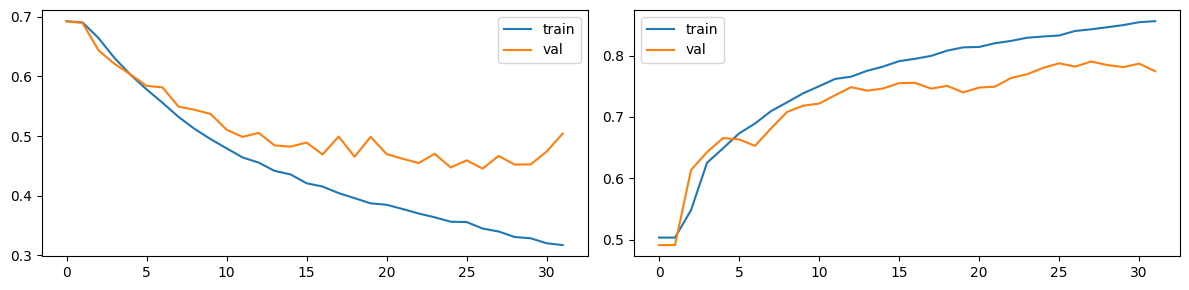

In [50]:
model = TorchLSTM(config)
trainer = Trainer(config, model, train_dataloader, val_dataloader)
history, last_ckpt_path = trainer.train()
show_history_graph(history)

In [51]:
print(last_ckpt_path)
model = TorchLSTM(config)
state_dict = torch.load(last_ckpt_path)
model.load_state_dict(state_dict)
model.to(config['device'])

loss, accuracy = trainer.test(model, test_dataloader)
print(f"test loss : {loss:.4f}, accuracy : {accuracy:.2f}")


output/TorchLSTM_ep_26_loss_0.4454.pt
test loss : 0.4957, accuracy : 0.78


# Using Transformer (BERT)

In [58]:
top_10000_word = sorted(word_cnt.items(), key=lambda item: item[1], reverse=True)[:10000]
vocab_cls = {'<PAD>':0, '<UNK>':1, '<CLS>':2 }
for item in top_10000_word:
    vocab_cls[item[0]] = len(vocab_cls)

print(vocab_cls)


# make word to integer token and add pad or truncate
max_len = 100
x_word_cls_token = []

for entry in x:
    sentence = [vocab_cls['<CLS>']]
    for word in entry.split()[:max_len-1]: # to use cls
        word = word.lower()
        token = vocab_cls[word] if word in vocab_cls else vocab_cls['<UNK>']
        sentence.append(token)
    pad_size = max_len - len(sentence)
    if pad_size > 0:
        sentence.extend([0]*pad_size)
    x_word_cls_token.append(sentence)

print("vocab_cls size:", len(vocab_cls))

x_word_cls_token = np.array(x_word_cls_token)
x_word_cls_token_tensors = torch.tensor(x_word_cls_token, dtype=torch.long)
y_tensors = torch.tensor(y, dtype=torch.long)
print(x_word_cls_token_tensors.shape)
print(y_tensors.shape)

imdb_cls_dataset = TensorDataset(x_word_cls_token_tensors, y_tensors)
train_cls_dataset, val_cls_dataset, test_cls_dataset = random_split(imdb_cls_dataset, [0.7, 0.15, 0.15])
print(f"train dataset:{len(train_cls_dataset)}, val dataset:{len(val_cls_dataset)}, test dataset:{len(test_cls_dataset)}")

train_cls_dataloader = DataLoader(train_cls_dataset, batch_size=config['batch_size'], shuffle=True)
val_cls_dataloader = DataLoader(val_cls_dataset, batch_size=config['batch_size'], shuffle=False)
test_cls_dataloader = DataLoader(test_cls_dataset, batch_size=config['batch_size'], shuffle=False)

{'<PAD>': 0, '<UNK>': 1, '<CLS>': 2, 'the': 3, 'a': 4, 'and': 5, 'of': 6, 'to': 7, 'is': 8, 'in': 9, 'i': 10, 'this': 11, 'that': 12, 'it': 13, '/><br': 14, 'was': 15, 'as': 16, 'with': 17, 'for': 18, 'but': 19, 'on': 20, 'movie': 21, 'are': 22, 'his': 23, 'not': 24, 'you': 25, 'film': 26, 'have': 27, 'he': 28, 'be': 29, 'at': 30, 'one': 31, 'by': 32, 'an': 33, 'they': 34, 'from': 35, 'all': 36, 'who': 37, 'like': 38, 'so': 39, 'just': 40, 'or': 41, 'has': 42, 'about': 43, 'her': 44, "it's": 45, 'if': 46, 'some': 47, 'out': 48, 'what': 49, 'very': 50, 'when': 51, 'there': 52, 'more': 53, 'would': 54, 'even': 55, 'my': 56, 'good': 57, 'she': 58, 'their': 59, 'only': 60, 'no': 61, 'really': 62, 'had': 63, 'up': 64, 'can': 65, 'which': 66, 'see': 67, 'were': 68, 'than': 69, 'we': 70, '-': 71, 'been': 72, 'get': 73, 'into': 74, 'will': 75, 'much': 76, 'because': 77, 'story': 78, 'how': 79, 'most': 80, 'other': 81, 'do': 82, 'also': 83, "don't": 84, 'time': 85, 'its': 86, 'me': 87, 'great':

In [51]:
class TorchTransformerEncoder(nn.Module):
    def __init__(self, config, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config['vocab_size'], 
            embedding_dim=config['embedding_dim']
            )
        
        self.transformer_enc_layer = nn.TransformerEncoderLayer(d_model=config['embedding_dim'], nhead=8, batch_first=True)
        self.transformer_enc = nn.TransformerEncoder(
            self.transformer_enc_layer,
            config['num_layers']
        )
        
        self.fnn = nn.Linear(
            in_features=config['embedding_dim'], 
            out_features=1
            )
        
    def forward(self, x):
        out = self.embedding(x)
        output = self.transformer_enc(out)
        # output ( batch, seq_len, input_size)
        cls_output = output[:, 0, :].squeeze()
        # cls_output = (batch, input_size)
        out = self.fnn(cls_output)
        return out

print(config['embedding_dim'])
config['vocab_size'] = len(vocab_cls)
model = TorchTransformerEncoder(config)
sample_input = train_cls_dataset[:config['batch_size']][0]
print(sample_input.shape)
test = model(sample_input)
print(test.shape)

64


NameError: name 'vocab_cls' is not defined

start training : lr=0.0001


 49%|████▉     | 49/100 [01:59<02:04,  2.43s/it, train_loss=0.33536, val_loss=0.41168, train_accu=0.85 val_accu=0.81]

Early stopping at epoch 49
output/TorchTransformerEncoder_ep_44_loss_0.4104.pt


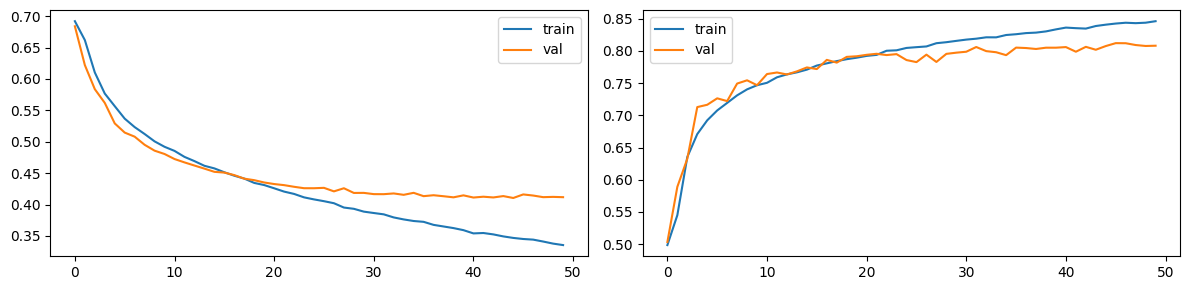

In [70]:
model = TorchTransformerEncoder(config)
trainer = Trainer(config, model, train_cls_dataloader, val_cls_dataloader)
history, last_ckpt_path = trainer.train()
show_history_graph(history)

# WordPiece encoding

In [49]:
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, trainers, processors
tokenizer = Tokenizer(models.WordPiece())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer.post_processor = processors.BertProcessing(sep=('[SEP]', 2), cls=('[CLS]', 3))
tokenizer.decoder = decoders.WordPiece()
token_trainer = trainers.WordPieceTrainer(
    vocab_size = 10000,
    special_tokens=["[PAD]", "[UNK]", "[SEP]", "[CLS]"],
    show_progress=True,
)

tokenizer.train_from_iterator(x, trainer=token_trainer)
max_len = 200
tokenizer.enable_truncation(max_len)
tokenizer.enable_padding(length=max_len)


print(x[0])
temp = tokenizer.encode(x[0]) 
print(temp.tokens)
print(temp.ids)
print(tokenizer.decode(temp.ids))




One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the 

In [44]:
x_word_piece_token_list = np.array([tokenizer.encode(entry).ids for entry in x])
print(x_word_piece_token_list.shape)        

(50000, 200)


In [45]:
x_tensors = torch.tensor(x_word_piece_token_list)
y_tensors = torch.tensor(y)
wp_dataset = TensorDataset(x_tensors, y_tensors)

train_wp_dataset, val_wp_dataset, test_wp_dataset = random_split(wp_dataset, lengths=[0.7, 0.15, 0.15])
train_wp_dataloder = DataLoader(train_wp_dataset, batch_size=config['batch_size'], shuffle=True)
val_wp_dataloader = DataLoader(val_wp_dataset, batch_size=config['batch_size'], shuffle=False)
test_wp_dataloader = DataLoader(test_wp_dataset, batch_size=config['batch_size'], shuffle=False)

start training : lr=0.0001


 16%|█▌        | 16/100 [03:30<18:22, 13.13s/it, train_loss=0.27585, val_loss=0.42347, train_accu=0.88 val_accu=0.81]

Early stopping at epoch 16
output/TorchTransformerEncoder_ep_11_loss_0.4071.pt


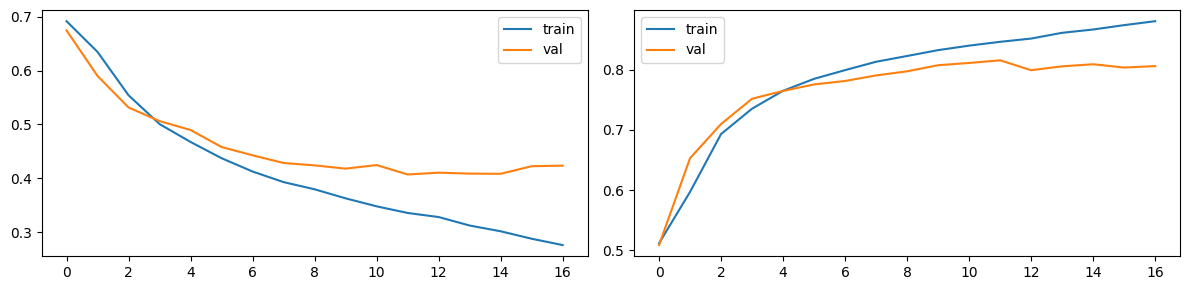

In [55]:
config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['epoch'] = 100
config['learning_rate'] = 1e-4
config['embedding_dim'] = 128
config['hidden_size'] = 512
config['num_layers'] = 2
config['vocab_size'] = tokenizer.get_vocab_size()
model = TorchTransformerEncoder(config)
trainer = Trainer(config, model, train_wp_dataloder, val_wp_dataloader)
history, last_ckpt_path = trainer.train()
show_history_graph(history)